# Visualizing Tweets and the Logistic Regression Model

This notebook demonstrates how to visualize tweet sentiment features and interpret a pretrained logistic regression model for sentiment analysis using the NLTK Twitter samples dataset.

**Objectives:**
- Visualize tweets in a scatter plot using their positive and negative feature sums.
- Overlay the logistic regression model's decision boundary and interpret its separation of sentiments.

## 1. Import Required Libraries

We will use NLTK for NLP tasks, pandas and numpy for data handling, matplotlib for visualization, and utility functions for tweet processing and feature extraction.

In [2]:
import nltk                         # NLP toolbox
from os import getcwd
import pandas as pd                 # Library for Dataframes 
from nltk.corpus import twitter_samples 
import matplotlib.pyplot as plt     # Library for visualization
import numpy as np                  # Library for math functions

nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

In [3]:
import re                           # Library for regular expressions
import string                       # Library for string operations
from nltk.corpus import stopwords   # Library for stopwords
from nltk.stem import PorterStemmer # Library for stemming
from nltk.tokenize import TweetTokenizer # Library for tokenizing strings

def process_tweet_custom(tweet):
    # Remove RT, URLs, and hashtags (keep the word)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    # Tokenize
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tokens = tokenizer.tokenize(tweet)
    # Remove stopwords and punctuation
    sw = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in sw and t not in string.punctuation]
    # Stemming
    stemmer = PorterStemmer()
    return [stemmer.stem(t) for t in tokens]


def build_freqs_custom(tweets, ys):
    yslist = np.squeeze(ys).tolist()
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet_custom(tweet):
            pair = (word, int(y))
            freqs[pair] = freqs.get(pair, 0) + 1
    return freqs

## 2. Load NLTK Twitter Sample Dataset

We will load positive and negative tweets from the NLTK `twitter_samples` corpus, concatenate them, and create corresponding sentiment labels.

In [4]:
# Select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# Concatenate the lists
tweets = all_positive_tweets + all_negative_tweets

# Create labels: 1 for positive, 0 for negative
labels = np.append(np.ones((len(all_positive_tweets), 1)), 
                   np.zeros((len(all_negative_tweets), 1)), axis=0)

# Split the data into training and validation sets
train_pos = all_positive_tweets[:4000]
train_neg = all_negative_tweets[:4000]
train_x = train_pos + train_neg

print("Number of tweets: ", len(train_x))

Number of tweets:  8000


## 3. Load Extracted Features from CSV

We use precomputed features for each tweet (bias, positive, negative, sentiment) stored in a CSV file. Let's load them using pandas.

In [5]:
# Generate logistic features for each tweet (bias, positive_sum, negative_sum, sentiment)
# This replaces the need for './data/logistic_features.csv'

# Build frequency dictionary from training data
freqs = build_freqs_custom(train_x, np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0))

def extract_features(tweet, freqs):
    """
    Extracts features for a single tweet:
    - bias: always 1
    - positive: sum of positive word frequencies
    - negative: sum of negative word frequencies
    """
    words = process_tweet_custom(tweet)
    pos = sum([freqs.get((w, 1), 0) for w in words])
    neg = sum([freqs.get((w, 0), 0) for w in words])
    return [1, pos, neg]

# Create features for all tweets in train_x
features = np.array([extract_features(tweet, freqs) for tweet in train_x])
sentiments = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0).flatten()

# Create DataFrame
data = pd.DataFrame(features, columns=['bias', 'positive', 'negative'])
data['sentiment'] = sentiments

data.head(10)

,bias,positive,negative,sentiment
0,1,3133,61,1.0
1,1,3705,444,1.0
2,1,3119,116,1.0
3,1,2975,4,1.0
4,1,3232,226,1.0
5,1,3070,120,1.0
6,1,4054,538,1.0
7,1,3280,278,1.0
8,1,656,189,1.0
9,1,266,114,1.0


## 4. Prepare Feature and Label Arrays

Extract the feature matrix `X` (bias, positive, negative) and label vector `Y` (sentiment) from the DataFrame and convert them to numpy arrays.

In [6]:
# Each feature is labeled as bias, positive, and negative
X = data[['bias', 'positive', 'negative']].values
Y = data['sentiment'].values

print(X.shape)  # Should be (8000, 3)
print(X[:5])    # Show first 5 rows of X

(8000, 3)
[[   1 3133   61]
 [   1 3705  444]
 [   1 3119  116]
 [   1 2975    4]
 [   1 3232  226]]


## 5. Load Pretrained Logistic Regression Model

Assign the pretrained logistic regression weights (theta) as a numpy array. These weights define the decision boundary for sentiment classification.

In [7]:
# Pretrained logistic regression weights (theta)
theta = np.array([6.03518871e-08, 5.38184972e-04, -5.58300168e-04])

## 6. Define Helper Functions for Visualization

We define two functions:
- `neg(theta, pos)`: Computes the negative axis value for the decision boundary given a positive value.
- `direction(theta, pos)`: Computes the direction vector for sentiment change, perpendicular to the decision boundary.

In [8]:
# Equation for the separation plane
def neg(theta, pos):
    """
    Given theta and a positive value, compute the corresponding negative value on the decision boundary.
    """
    return (-theta[0] - pos * theta[1]) / theta[2]

# Equation for the direction of sentiment change
def direction(theta, pos):
    """
    Compute the direction vector for sentiment change (perpendicular to the decision boundary).
    """
    return pos * theta[2] / theta[1]

## 7. Scatter Plot of Tweets by Sentiment

Plot the tweets in a scatter plot using their positive and negative feature sums. Color the points by sentiment: green for positive, red for negative.

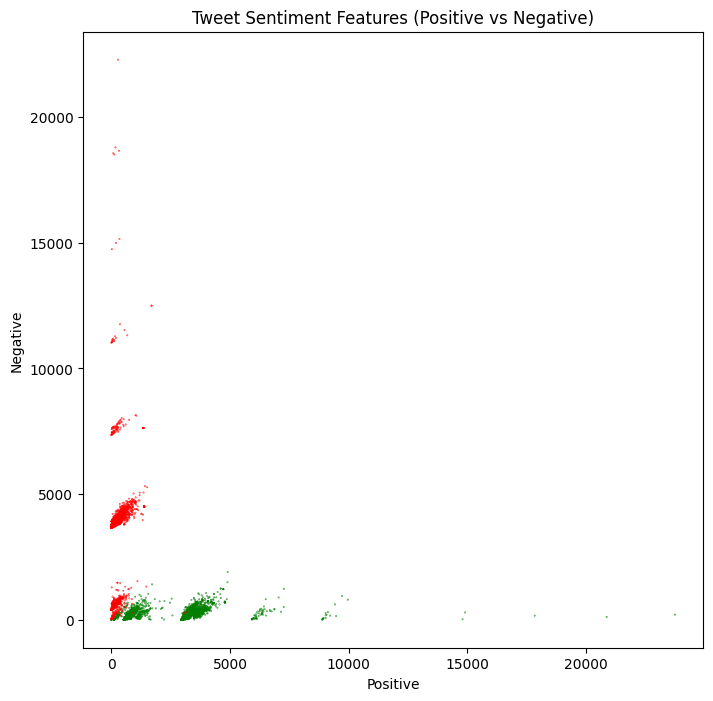

In [9]:
# Plot the samples using columns 1 (positive) and 2 (negative) of the matrix
fig, ax = plt.subplots(figsize=(8, 8))

colors = ['red', 'green']

# Color based on the sentiment Y
ax.scatter(X[:, 1], X[:, 2], c=[colors[int(k)] for k in Y], s=0.1)
plt.xlabel("Positive")
plt.ylabel("Negative")
plt.title("Tweet Sentiment Features (Positive vs Negative)")
plt.show()

## 8. Plot Logistic Regression Decision Boundary and Directions

Overlay the logistic regression decision boundary (gray line) and direction arrows (green for positive, red for negative) on the scatter plot to visualize how the model separates the sentiments.

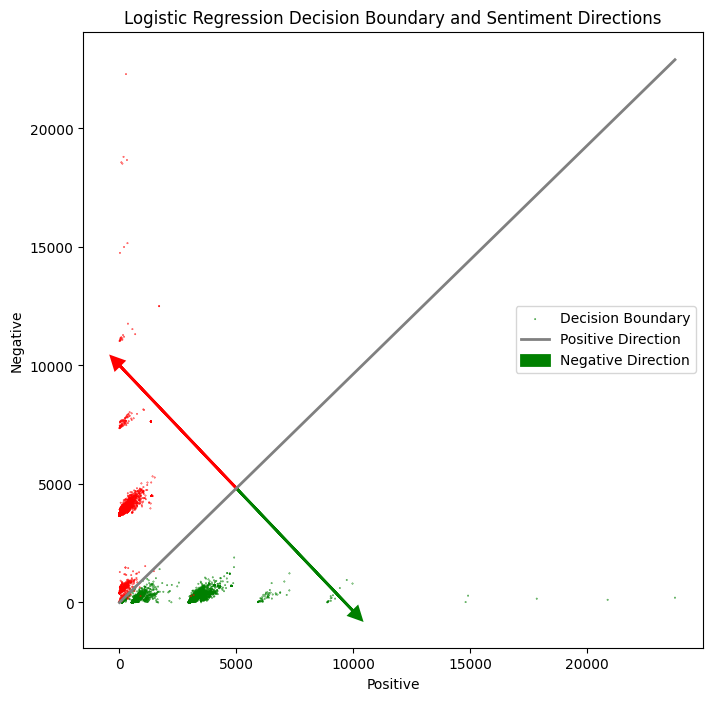

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot as before
ax.scatter(X[:, 1], X[:, 2], c=[colors[int(k)] for k in Y], s=0.1)
plt.xlabel("Positive")
plt.ylabel("Negative")
plt.title("Logistic Regression Decision Boundary and Sentiment Directions")

# Decision boundary
maxpos = np.max(X[:, 1])
offset = 5000  # The pos value for the direction vectors' origin

# Plot a gray line that divides the 2 areas
ax.plot([0, maxpos], [neg(theta, 0), neg(theta, maxpos)], color='gray', linewidth=2, label='Decision Boundary')

# Plot a green arrow pointing to the positive direction
ax.arrow(offset, neg(theta, offset), offset, direction(theta, offset), 
         head_width=500, head_length=500, fc='g', ec='g', linewidth=2, label='Positive Direction')

# Plot a red arrow pointing to the negative direction
ax.arrow(offset, neg(theta, offset), -offset, -direction(theta, offset), 
         head_width=500, head_length=500, fc='r', ec='r', linewidth=2, label='Negative Direction')

plt.legend(['Decision Boundary', 'Positive Direction', 'Negative Direction'])
plt.show()

**Note:** The features extracted from tweets (positive and negative word sums) are crucial for the model's high accuracy. The logistic regression model's effectiveness in this task is largely due to the quality of these features.

That's all! You have now visualized tweet sentiment features and interpreted the logistic regression model's decision boundary for sentiment analysis.